# **Ансамблевая классификация**

1. Разработайте программу, которая выполняет классификацию заданного набора данных с помощью одной из техник ансамблевой классификации. Параметрами программы являются набор данных, ансамблевая техника (бэггинг, случайный лес или бустинг), количество участников ансамбля, а также параметры в соответствии с выбранной техникой ансамблевой классификации.
2. Проведите эксперименты на наборе данных из задания "Классификация с помощью дерева решений", варьируя количество участников ансамбля (от 50 до 100 с шагом 10).
3. Выполните визуализацию полученных результатов в виде следующих диаграмм:

- показатели качества классификации в зависимости от количества участников ансамбля для заданного набора данных; нанесите на диаграмму соответствующие значения, полученные в задании "Классификация с помощью дерева решений".

Подключим используемые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

Загрузим набор данных из предыдущего задания, по условию объединим тестовый и обучающий, посмотрим на него.

In [3]:
train_data_path = "train.csv"
test_data_path = "test.csv"
col_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
             "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
             "hours-per-week", "native-country", "income"]

train = pd.read_csv('train.csv', names=col_names, na_values=" ?")
test = pd.read_csv('test.csv', names=col_names, na_values=" ?")

df =  pd.concat([train, test])
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16277,64,NaN,321403,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16278,38,Private,374983,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16279,44,Private,83891,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


Выполним предобработку данных аналогично из предыдущего задания.

In [4]:
def balance_dataset(df):
    """Балансировка датасета"""
    X = df.drop(columns=['income'])
    y = df['income']
    y_numeric = (y == ' >50K').astype(int)

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y_numeric)

    X_balanced = pd.DataFrame(X_resampled, columns=X.columns)
    y_balanced = pd.Series(y_resampled)
    balanced_dataset = pd.concat([X_balanced, y_balanced], axis=1)
    balanced_dataset['income'] = balanced_dataset['income'].map({0: ' <=50K', 1: ' >50K'})

    return balanced_dataset

def preprocess_data(df):
    """Функция предобработки данных."""
    df = balance_dataset(df)
    df = df.dropna()
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    # Преобразование категориальных признаков в числовые
    label_encoders = {}
    for col in df.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    return df, label_encoders

df, label_encoders = preprocess_data(df)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,77516,9,13.0,4,0,1,4,1,2174.0,0.0,40.0,38,0
1,50,4,83311,9,13.0,2,3,0,4,1,0.0,0.0,13.0,38,0
2,38,2,215646,11,9.0,0,5,1,4,1,0.0,0.0,40.0,38,0
3,53,2,234721,1,7.0,2,5,0,2,1,0.0,0.0,40.0,38,0
4,28,2,338409,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71774,54,0,33863,11,9.0,2,0,0,4,1,0.0,0.0,40.0,38,1
71776,59,0,190541,11,9.0,2,2,0,4,1,0.0,0.0,40.0,38,1
71777,40,1,27444,9,13.0,4,9,1,4,1,0.0,0.0,50.0,38,1
71779,35,2,209214,11,9.0,2,0,5,4,0,4386.0,0.0,35.0,38,1


Выполним обучение с использованием критериев, в том числе с выбором ансамблиевой техники и кол-вом участников, и разбиеним данных, а также вычислим значения метрик.

In [8]:
X = df.drop(columns=["income"])
y = df["income"]

def train_and_evaluate(X, y, ensemble_technique='random_forest', n_estimators=100, max_depth=15, test_size=0.2):
    """Обучение и оценка модели дерева решений."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    if ensemble_technique == 'random_forest':
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif ensemble_technique == 'bagging':
        base_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        clf = BaggingClassifier(base_clf, n_estimators=n_estimators, random_state=42)
    elif ensemble_technique == 'boosting':
        clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    else:
        raise ValueError("Неподдерживаемая ансамблиевая техника")

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }

    return clf, metrics

# Обучение модели
technique = "random_forest"
n_estimators = 150
max_depth = 15
test_size = 0.2
clf, metrics = train_and_evaluate(X, y, ensemble_technique=technique,
                                  n_estimators=n_estimators, max_depth=max_depth, test_size=test_size)
metrics

{'Accuracy': 0.8611564121571534,
 'Precision': 0.8009801577814966,
 'Recall': 0.9698943407150095,
 'F1': 0.8773813420621931}

# **Эксперименты на наборе данных**

Выполним эксперименты с фиксацией ансамблиевой техники и варьированием количества участников ансамбля от 50 до 100 с шагом 10 и посмотрим на результат метрик.

In [9]:
n_estimators_values = [50, 60, 70, 80, 90, 100]
techniques = ['random_forest', 'bagging', 'boosting']

results = {}

for technique in techniques:
    results[technique] = {'n_estimators': [], 'metrics': []}

    for n_estimators in n_estimators_values:
        clf, metrics = train_and_evaluate(X, y, ensemble_technique=technique, n_estimators=n_estimators, max_depth=15, test_size=0.2)

        results[technique]['n_estimators'].append(n_estimators)
        results[technique]['metrics'].append(metrics)

for technique in techniques:
    print(f"Результаты для техники '{technique}':")
    print("Доля обучающей выборки  | Accuracy | Precision | Recall | F1")
    for i in range(len(n_estimators_values)):
        print(f"{results[technique]['n_estimators'][i]} | "
              f"{results[technique]['metrics'][i]['Accuracy']:.4f} | "
              f"{results[technique]['metrics'][i]['Precision']:.4f} | "
              f"{results[technique]['metrics'][i]['Recall']:.4f} | "
              f"{results[technique]['metrics'][i]['F1']:.4f}")
    print("\n")

Результаты для техники 'random_forest':
Доля обучающей выборки  | Accuracy | Precision | Recall | F1
50 | 0.8594 | 0.7986 | 0.9700 | 0.8760
60 | 0.8604 | 0.7992 | 0.9715 | 0.8770
70 | 0.8602 | 0.7987 | 0.9721 | 0.8769
80 | 0.8603 | 0.7993 | 0.9709 | 0.8768
90 | 0.8604 | 0.7997 | 0.9705 | 0.8769
100 | 0.8609 | 0.8000 | 0.9711 | 0.8773


Результаты для техники 'bagging':
Доля обучающей выборки  | Accuracy | Precision | Recall | F1
50 | 0.8729 | 0.8082 | 0.9857 | 0.8882
60 | 0.8727 | 0.8083 | 0.9851 | 0.8880
70 | 0.8724 | 0.8084 | 0.9842 | 0.8877
80 | 0.8721 | 0.8080 | 0.9842 | 0.8874
90 | 0.8726 | 0.8086 | 0.9844 | 0.8879
100 | 0.8734 | 0.8090 | 0.9854 | 0.8885


Результаты для техники 'boosting':
Доля обучающей выборки  | Accuracy | Precision | Recall | F1
50 | 0.9083 | 0.8523 | 0.9931 | 0.9173
60 | 0.9164 | 0.8634 | 0.9941 | 0.9241
70 | 0.9221 | 0.8708 | 0.9957 | 0.9290
80 | 0.9257 | 0.8758 | 0.9962 | 0.9322
90 | 0.9284 | 0.8798 | 0.9962 | 0.9344
100 | 0.9305 | 0.8830 | 0.9962 | 0.9362

# Визуализация метрик в виде диаграмм

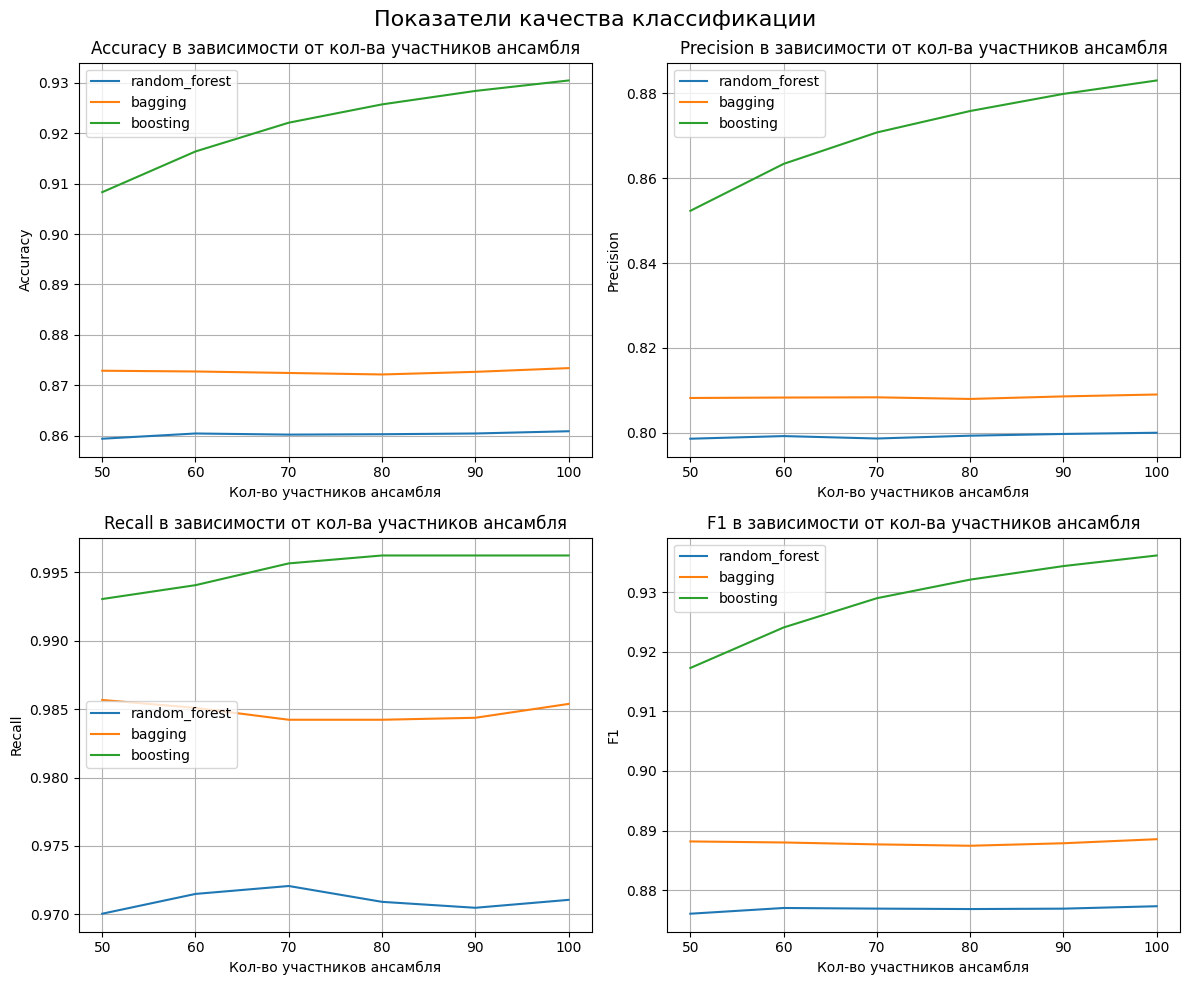

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics_names = ["Accuracy", "Precision", "Recall", "F1"]
for i, metric_name in enumerate(metrics_names):
    ax = axes[i]
    for technique in techniques:
        values = [results[technique]['metrics'][i][metric_name] for i in range(len(n_estimators_values))]
        ax.plot(n_estimators_values, values, label=f"{technique}")

    ax.set_xlabel("Кол-во участников ансамбля")
    ax.set_ylabel(metric_name)
    ax.set_title(f"{metric_name} в зависимости от кол-ва участников ансамбля")
    ax.legend()
    ax.grid(True)


fig.suptitle('Показатели качества классификации', fontsize=16)
plt.tight_layout()
plt.show()